In [40]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

In [41]:
from scipy.stats import pearsonr,spearmanr

In [42]:
from gplearn.genetic import SymbolicRegressor,SymbolicTransformer
from gplearn import fitness
from gplearn.functions import make_function
from gplearn.fitness import make_fitness

In [43]:
# 自定义算子
def _Add(data1,data2):
    if len(np.unique(data1))<=1 or len(np.unique(data2))<=1:
        return np.zeros(len(data1))
    else:
        return np.add(data1,data2)
    
def _Sub(data1,data2):
    if len(np.unique(data1))<=1 or len(np.unique(data2))<=1:
        return np.zeros(len(data1))
    else:
        return np.subtract(data1,data2)
    
def _Mul(data1,data2):
    if len(np.unique(data1))<=1 or len(np.unique(data2))<=1:
        return np.zeros(len(data1))
    else:
        return np.multiply(data1,data2)
    
def _Div(data1,data2):
    def protect_division(data1,data2):
        with np.errstate(divide='ignore',invalid='ignore'):
            return np.where(np.abs(data2)>0.001,np.divide(data1,data2),0.)
    if len(np.unique(data1))<=1 or len(np.unique(data2))<=1:
        return np.zeros(len(data1))
    else:
        return protect_division(data1,data2)
    
def _Sqrt(data):
    if len(np.unique(data))<=1:
        return np.zeros(len(data))
    else:
        return np.sqrt(np.abs(data))
    
def _Log(data):
    def protect_log(data):
        with np.errstate(divide='ignore',invalid='ignore'):
            return np.where(np.abs(data) > 0.001, np.log(np.abs(data)), 0.)
    if len(np.unique(data))<=1:
        return np.zeros(len(data))
    else:
        return protect_log(data)
    
def _Inv(data):
    data=np.array(data)
    def protect_inv(data):
        with np.errstate(divide='ignore',invalid='ignore'):
            return np.where(np.abs(data) > 0.001, 1./data, 0.)
    if len(np.unique(data))<=1:
        return np.zeros(len(data))
    else:
        return protect_inv(data)

def _ts_max(data,window): #历史rolling最大
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).max())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))

def _ts_min(data,window): #历史rolling最小
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).min())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))

def _ts_mid(data,window): #历史rolling中位数
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).median())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))


def _ts_mean(data,window):  #历史rolling平均
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).mean())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))


def _ts_std(data,window): #历史rolling std
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).std())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))
    
    
def _ts_sum(data,window): #历史rolling求和
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).mean())
        return np.nan_to_num(value.values*window)
    except:
        return np.zeros(len(data))
    
    
def _ts_product(data,window): #历史rolling求积
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':np.log(data)})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).mean())
        return np.nan_to_num(np.exp(value.values*window))
    except:
        return np.zeros(len(data))

    
def _delay(data,window):  # 几天以前的因子值
    window=window[0]
    if window not in [1,5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x : x.shift(window))
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))

    
def _delta(data,window):  # 因子值与几天前的因子值之差
    window=window[0]
    if window not in [1,5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code')['data'].transform(lambda x : x.shift(window))
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))

    
def _rank(data):  # 因子在截面上的分位数
    if len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('date')['data'].transform(lambda s : s.rank()/s.count())
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))
    
    
def _ts_rank(data,window):  # 因子在过去几天中的分位数
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code  
        value=df.groupby('code')['data'].transform(lambda x:x.rolling(window).rank()/window)
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data))
    
    
def _sigmoid(data):
    data=np.array(data)
    with np.errstate(over='ignore',under='ignore'):
        return 1/(1+np.exp(-1*data))
    
    
def _correlation(data1,data2,window):
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data1))<=2 or len(np.unique(data2))<=2:
        return np.zeros(len(data1))
    try:
        df=pd.DataFrame({'data1':data1,'data2':data2})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code').apply(lambda df : df.data1.rolling(window).corr(df.data2)) # 因为code排序是按顺序的所以可以用apply
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data1))
    
    
def _covariance(data1,data2,window):
    window=window[0]
    if window not in [5,10,20,40,60] or len(np.unique(data1))<=2 or len(np.unique(data2))<=2:
        return np.zeros(len(data1))
    try:
        df=pd.DataFrame({'data1':data1,'data2':data2})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code').apply(lambda df : df.data1.rolling(window).cov(df.data2)) # 因为code排序是按顺序的所以可以用apply
        return np.nan_to_num(value.values)
    except:
        return np.zeros(len(data1))
    
    
def _scale(data):
    if len(np.unique(data))<=2:
        return np.zeros(len(data))
    else:
        return np.divide(data,np.sum(np.abs(data)))
    
    
def _decay_linear(data,window):  # 因子过去几天的加权平均值，权数随时间往前线性递减
    window=window[0]    
    if  window not in [5,10,20,40,60] or len(np.unique(data))<=2:
        return np.zeros(len(data))
    try:
        w=np.arange(1,window+1)
        w=w/np.sum(w)
        df=pd.DataFrame({'data':data})
        df['date']=test_date
        df['code']=test_code
        value=df.groupby('code').data.transform(lambda x:x.rolling(window).apply(lambda s:np.dot(w,s.values)).values)
        return np.nan_to_num(value)
    except:
        return np.zeros(len(data))
Add=make_function(function=_Add,name='Add',arity=2)
Sub=make_function(function=_Sub,name='Sub',arity=2)
Mul=make_function(function=_Mul,name='Mul',arity=2)
Div=make_function(function=_Div,name='Div',arity=2)
Log=make_function(function=_Log,name='Log',arity=1)
Sqrt=make_function(function=_Sqrt,name='Sqrt',arity=1)
Inv=make_function(function=_Inv,name='Inv',arity=1)
ts_max=make_function(function=_ts_max,name='ts_max',arity=2) 
ts_min=make_function(function=_ts_min,name='ts_min',arity=2) 
ts_mid=make_function(function=_ts_mid,name='ts_mid',arity=2) 
ts_mean=make_function(function=_ts_mean,name='ts_mean',arity=2) 
ts_std=make_function(function=_ts_std,name='ts_std',arity=2)
delay=make_function(function=_delay,name='delay',arity=2)
delta=make_function(function=_delta,name='delta',arity=2)
rank=make_function(function=_rank,name='rank',arity=1)
sigmoid=make_function(function=_sigmoid,name='sigmoid',arity=1)
correlation=make_function(function=_correlation,name='correlation',arity=3)
covariance=make_function(function=_covariance,name='covariance',arity=3)
scale=make_function(function=_scale,name='scale',arity=1)
ts_rank=make_function(function=_ts_rank,name='ts_rank',arity=2)
ts_sum=make_function(function=_ts_sum,name='ts_sum',arity=2)
ts_product=make_function(function=_ts_product,name='ts_product',arity=2)

In [44]:
post=ff.read('post')
filter0=ff.filter0
close=ff.read('close')*post*filter0
open_=ff.read('open')*post*filter0
high=ff.read('high')*post*filter0
low=ff.read('low')*post*filter0
vol=ff.read('vol')*filter0
amount=ff.read('amount')*post*filter0

In [45]:
inds = pd.read_pickle('/mydata2/wangs/data/dict_ind_matrix_sw1.pk')

In [46]:
result = pd.DataFrame(columns=['因子','夏普率','收益率','mkt_'])

In [47]:
mkv=(ff.read('mkv','factor')*filter0).loc[close.index,'20200101':'20210101']
mkv_s=mkv.values.reshape(-1)

In [48]:
mkt20=close.shift(-1,axis=1)/close - 1

In [49]:
factor_names1=['closer', 'openr', 'lowr', 'highr', 'ocret', 'lcret', 'hcret', 'ohret', 'ret5', 'ret10', 'ret20', 'ret30', 'excess5', 'excess10', 'excess20', 'excess30', 'ma5', 'bias5', 'ma10',
               'bias10', 'ma15', 'bias15', 'ma20', 'bias20', 'vwap_ret', 'vwaph_ret', 'll5', 'll15', 'll20', 'll30', 'a0', 'a5', 'a15', 'a30', 'ah5', 'ah10', 'ah15', 'std', 'amt_std', 'vol_std', 
               'amt_mean', 'vol_mean', 'turnover', 'turnover_mean', 'turnover_std', 'turnover_skew', 'turnoverf', 'turnoverf_mean', 'turnoverf_std', 'turnoverf_skew', 'mkv', 'l_mkv', 'lhret', 
               'STR', 'MTR', 'SMTR', 'ILLIQ','close','high','low']
factor_names2=['ARRP', 'ARRP_5d_20mean', 'AmpMod', 'BVol', 'CDPDVP', 'ILLIQ', 'IVoldeCorr', 'IntraDayMom20', 'MTR', 'RCP', 'SMTR', 'SPS', 'STR', 'a30', 
               'afternoon_ratio_1', 'ah15', 'amt', 'amt_ma20', 'amt_mean', 'amt_score0', 'amt_score1', 'amt_score2', 'amt_std', 'amt_std20', 'bias10', 'bias15', 'bias20', 'bias5', 
               'cross_std10', 'cross_std10adj', 'ctrade', 'excess10', 'excess20', 'excess30', 'excess5', 'growth_a', 'growth_b', 'growth_c', 'h_rankamt_corr_10', 'h_rankv_corr_10', 'h_rankv_corr_36', 
               'hcret', 'idiov', 'intro_high80_corr', 'ivr', 'l_mkv', 'mkv', 'mom1', 'mom_spring', 'nl_mkv', 'nl_mom', 'open0931ratio', 'open5ratio_ma10vol', 'rank_2_corr_hv10', 'rank_2_corr_hv20', 'rank_ha_corr_sum', 
               'ret20', 'ret30', 'ret5', 'roc121', 'roc20', 'roc240', 'roc5', 'scr', 'std', 'std20', 'std21', 'std240', 'stddev_cov', 'stddev_cov_right', 'sub', 'sysv', 'tail_ratio_1', 'tailrets0', 'tailrets1', 'tliq', 
               'turn20', 'turnover', 'turnover_mean', 'turnover_scale_z', 'turnover_score_ts_mean', 'turnover_score_ts_std', 'turnover_skew', 'turnover_std', 'turnoverf', 'turnoverf_mean', 'turnoverf_skew', 'turnoverf_std', 
               'up_KURS', 'up_plus_down_KURS', 'vol', 'vol_mean', 'vol_std', 'vol_std20', 'volroc_skew', '滞后日内量价corr']
factor_names3 =['accelerated_turnover_rank_RC','CSK_XYY_UP_DOWN_120D_RC','high_fre_vol_RC','high_fre_diff_vol_RC','high_fre_absdiff_vol_RC','peak_count_vol_RC','overnightsmart20_RC','CTR_RC','jumpCTR_RC','turnover_rate_proportion_l','synergy']
fields = factor_names1 + factor_names2 + factor_names3

In [50]:
stock_test=pd.DataFrame()
for factor in fields:
    data = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20210101'].columns)
    stock_test[factor] = (data.rank()/data.count()).values.reshape(-1)
test_code=[code for code in close.index for i in close.loc[:,'20200101':'20210101'].columns]
test_date=close.loc[:,'20200101':'20210101'].columns.to_list() *len(close.index)
stock_test['code']=test_code
stock_test['date']=test_date
stock_test['1'],stock_test['5'],stock_test['10'],stock_test['20'],stock_test['40'],stock_test['60']=1,5,10,20,40,60

In [51]:
stock_test

,closer,openr,lowr,highr,ocret,lcret,hcret,ohret,ret5,ret10,...,turnover_rate_proportion_l,synergy,code,date,1,5,10,20,40,60
0,0.774692,0.869269,0.925170,0.682047,0.634939,0.614839,0.676914,0.548478,0.643655,0.581829,...,NaN,NaN,000001.SZ,20200102,1,5,10,20,40,60
1,0.851131,0.794648,0.971614,0.787108,0.820035,0.669031,0.622931,0.751478,0.774277,0.736390,...,0.500148,NaN,000001.SZ,20200103,1,5,10,20,40,60
2,0.210707,0.236025,0.402839,0.374002,0.345449,0.230201,0.316785,0.498522,0.400515,0.518763,...,0.500148,NaN,000001.SZ,20200106,1,5,10,20,40,60
3,0.346594,0.748227,0.419622,0.388593,0.225340,0.308624,0.411991,0.259303,0.447753,0.419507,...,0.500148,NaN,000001.SZ,20200107,1,5,10,20,40,60
4,0.207153,0.221713,0.286115,0.089513,0.303334,0.202420,0.539982,0.288728,0.474091,0.325408,...,0.500148,NaN,000001.SZ,20200108,1,5,10,20,40,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201225,1,5,10,20,40,60
1346945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201228,1,5,10,20,40,60
1346946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201229,1,5,10,20,40,60
1346947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,T00018.SH,20201230,1,5,10,20,40,60


In [52]:
test_mkt = mkt20.loc[:,'20200101':'20210101'].values.reshape(-1)
# test_mkt=(mkt20.loc[:,'20200101':'20210101'].rank()/mkt20.loc[:,'20200101':'20210101'].count()).values.reshape(-1)

In [53]:
import statsmodels.api as sm

def rankIC_metric(y,y_pred,w=None):
    
    def cal_rankIC(df):
        df.index=df.code
        # 去极值
        M=df.y_pred.mean()    #df.y_pred.median()
        M1=df.y_pred.std()    #(df.y_pred-M).abs().median()
        df.y_pred.loc[df.y_pred>M+3*M1]=M+3*M1    #5
        df.y_pred.loc[df.y_pred<M-3*M1]=M-3*M1
        # 行业市值中性化
        day=df.date.iloc[0]
        ind=inds[day].copy()
        ind['mkv']=df.loc[ind.index,'mkv']
        input_x=ind.dropna().astype(float)
        input_y=df.loc[input_x.index,'y_pred']
        y_true=df.loc[input_x.index,'y'].values
        if len(input_x)==0:
            return 0
        else:
            mod=sm.OLS(input_y,input_x)
            res=mod.fit()
            y_adj=res.resid
            #标准化
            y_adj=(y_adj-y_adj.mean())/y_adj.std()
        
            if len(np.unique(y_adj.values)) <=2:
                return 0
            else:
                #return y_adj.corr(input_xy.mkt_delay,method='spearman')
                return spearmanr(np.nan_to_num(y_adj.values),np.nan_to_num(y_true))[0]
            
    if len(np.unique(y_pred))<=2:
        return 0
    else:
        try:
            data=pd.DataFrame({'y_pred':y_pred,'y':y,'mkv':np.log(mkv_s),'code':test_code,'date':test_date})
            res=data.groupby('date').apply(cal_rankIC)
            return np.abs(np.nanmean(res))
        except:
            return 0

In [54]:
rankIC=make_fitness(function=rankIC_metric,greater_is_better=True)

In [55]:
init_function = ['add','sub','mul','div','sqrt','log','inv','abs','neg']
user_function=[ts_max,ts_min,ts_mid,ts_mean,ts_std,delay,delta,rank,correlation,ts_rank]
function_set=init_function+user_function

In [56]:
test_gp=SymbolicTransformer(feature_names = fields,
                            function_set = function_set, #所有算子
                            generations = 3, #进化代数
                            population_size = 200, #种群规模
                            tournament_size = 10, #竞标赛规模
                            p_crossover=0.4,
                            p_subtree_mutation=0.05,
                            p_hoist_mutation=0.01,
                            p_point_mutation=0.03,
                            p_point_replace=0.35,
                            init_depth=(1,4),
                            const_range = None,
                            metric=rankIC,
                            parsimony_coefficient = 'auto',
                            low_memory=True,
                            verbose=2,
                            n_jobs = 6)

In [57]:
test_gp.fit(np.nan_to_num(stock_test.loc[:,fields].values),np.nan_to_num(test_mkt))

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  1.5min remaining:  2.9min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.9min finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


   0     7.05       0.00913089        2        0.0599776              N/A      3.78m


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  3.3min remaining:  6.7min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  5.0min finished


   1     5.05        0.0345725        1        0.0741841              N/A      4.96m


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  3.9min remaining:  7.9min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  6.9min finished


   2     4.59        0.0471067        1        0.0741841              N/A      0.00s


SymbolicTransformer(const_range=None,
                    feature_names=['closer', 'openr', 'lowr', 'highr', 'ocret',
                                   'lcret', 'hcret', 'ohret', 'ret5', 'ret10',
                                   'ret20', 'ret30', 'excess5', 'excess10',
                                   'excess20', 'excess30', 'ma5', 'bias5',
                                   'ma10', 'bias10', 'ma15', 'bias15', 'ma20',
                                   'bias20', 'vwap_ret', 'vwaph_ret', 'll5',
                                   'll15', 'll20', 'll30', ...],
                    function_set=['add', 'sub', 'mul', 'div', 'sqrt...
                                  <gplearn.functions._Function object at 0x7ff12d32eeb0>,
                                  <gplearn.functions._Function object at 0x7ff1f0b3d910>],
                    generations=3, init_depth=(1, 4), low_memory=True,
                    metric=<gplearn.fitness._Fitness object at 0x7ff12d27afa0>,
                    n_jobs=6, p_crossover=0.4, p_point_mutation=0.03,
                    p_point_replace=0.35, p_subtree_mutation=0.05,
                    parsimony_coefficient='auto', population_size=200,
                    tournament_size=10, verbose=2)

In [58]:
stock_all=pd.DataFrame()
for factor in fields:
    stock_all[factor] = pd.DataFrame(ff.read(factor),index=open_.index,columns=ff.read('synergy').loc[:,'20200101':'20240101'].columns).values.reshape(-1)
test_code=[code for code in close.index for i in close.loc[:,'20200101':'20240101'].columns]
test_date=close.loc[:,'20200101':'20240101'].columns.to_list() *len(close.index)
stock_all['code']=test_code
stock_all['date']=test_date
stock_all['1'],stock_all['5'],stock_all['10'],stock_all['20'],stock_all['40'],stock_all['60']=1,5,10,20,40,60

Program 1: bias15
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


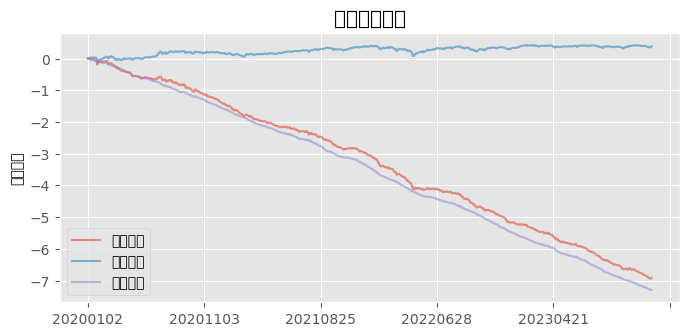

,指数收益,超额收益,策略收益
年化收益率,0.099,-1.881,-1.783
年化波动率,0.201,0.115,0.242
夏普率,0.495,-16.296,-7.362
最大回撤,-0.325,-7.289,-6.942
收益回撤比,0.305,-0.258,-0.257
胜率,0.534,0.123,0.310
盈亏比,0.948,0.466,0.618


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


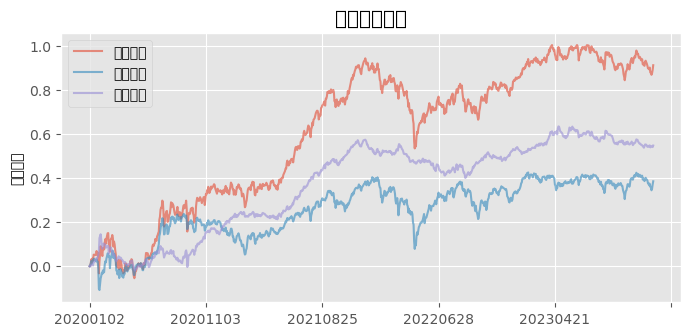

,指数收益,超额收益,策略收益
年化收益率,0.099,0.141,0.235
年化波动率,0.201,0.122,0.257
夏普率,0.495,1.162,0.916
最大回撤,-0.325,-0.173,-0.409
收益回撤比,0.305,0.814,0.575
胜率,0.534,0.540,0.539
盈亏比,0.948,1.041,0.995


Program 2: neg(turnoverf)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


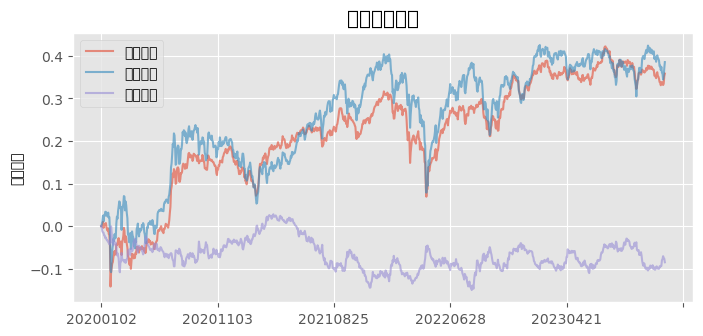

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.022,0.092
年化波动率,0.201,0.105,0.146
夏普率,0.495,-0.208,0.630
最大回撤,-0.325,-0.178,-0.247
收益回撤比,0.305,-0.123,0.373
胜率,0.534,0.464,0.526
盈亏比,0.948,1.114,1.011


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


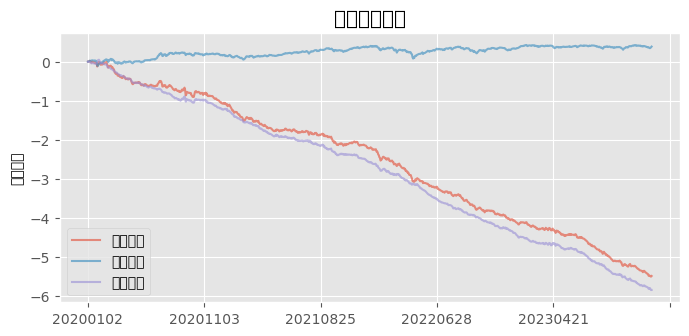

,指数收益,超额收益,策略收益
年化收益率,0.099,-1.506,-1.414
年化波动率,0.201,0.224,0.326
夏普率,0.495,-6.726,-4.341
最大回撤,-0.325,-5.892,-5.522
收益回撤比,0.305,-0.256,-0.256
胜率,0.534,0.326,0.401
盈亏比,0.948,0.673,0.723


Program 3: sqrt(turnoverf)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


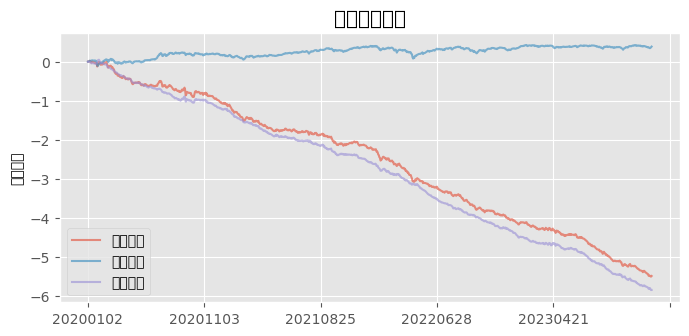

,指数收益,超额收益,策略收益
年化收益率,0.099,-1.506,-1.414
年化波动率,0.201,0.224,0.326
夏普率,0.495,-6.726,-4.341
最大回撤,-0.325,-5.892,-5.522
收益回撤比,0.305,-0.256,-0.256
胜率,0.534,0.326,0.401
盈亏比,0.948,0.673,0.723


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


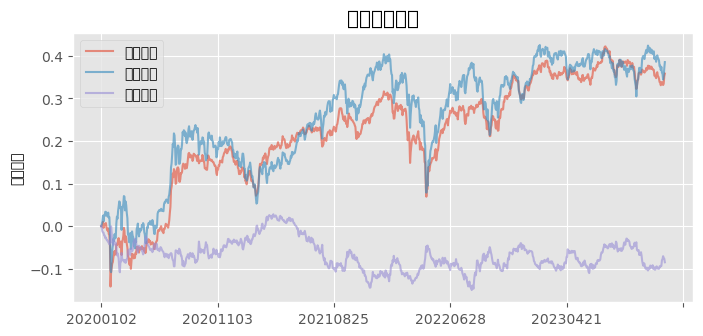

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.022,0.092
年化波动率,0.201,0.105,0.146
夏普率,0.495,-0.208,0.630
最大回撤,-0.325,-0.178,-0.247
收益回撤比,0.305,-0.123,0.373
胜率,0.534,0.464,0.526
盈亏比,0.948,1.114,1.011


Program 4: add(vol_mean, sqrt(turnoverf))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


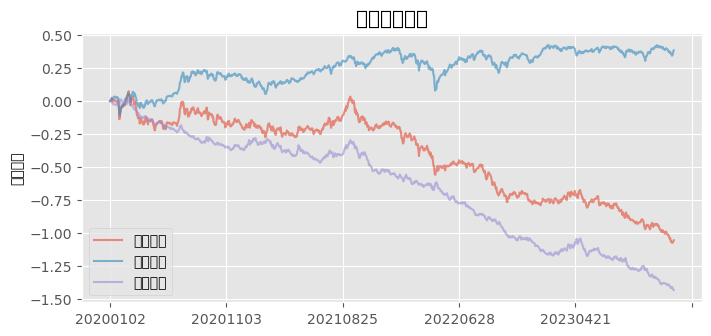

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.370,-0.273
年化波动率,0.201,0.152,0.260
夏普率,0.495,-2.432,-1.047
最大回撤,-0.325,-1.455,-1.152
收益回撤比,0.305,-0.254,-0.237
胜率,0.534,0.415,0.489
盈亏比,0.948,0.946,0.877


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


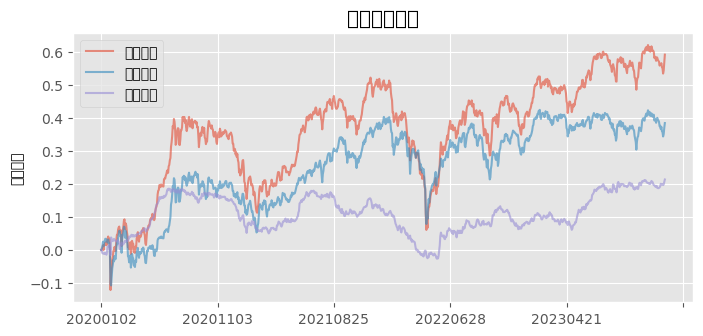

,指数收益,超额收益,策略收益
年化收益率,0.099,0.055,0.153
年化波动率,0.201,0.089,0.227
夏普率,0.495,0.623,0.675
最大回撤,-0.325,-0.213,-0.463
收益回撤比,0.305,0.259,0.331
胜率,0.534,0.505,0.552
盈亏比,0.948,1.089,0.911


Program 5: inv(inv(up_KURS))
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


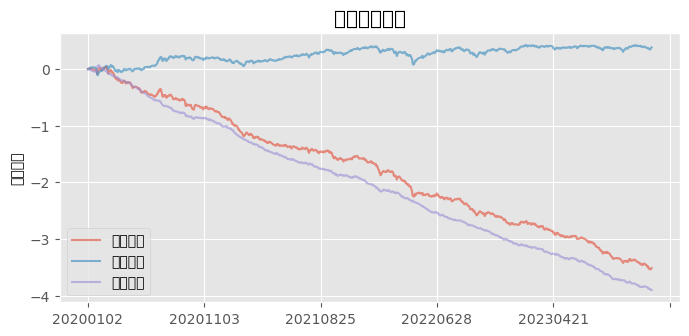

,指数收益,超额收益,策略收益
年化收益率,0.099,-1.005,-0.905
年化波动率,0.201,0.119,0.234
夏普率,0.495,-8.451,-3.864
最大回撤,-0.325,-3.968,-3.578
收益回撤比,0.305,-0.253,-0.253
胜率,0.534,0.273,0.414
盈亏比,0.948,0.664,0.739


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


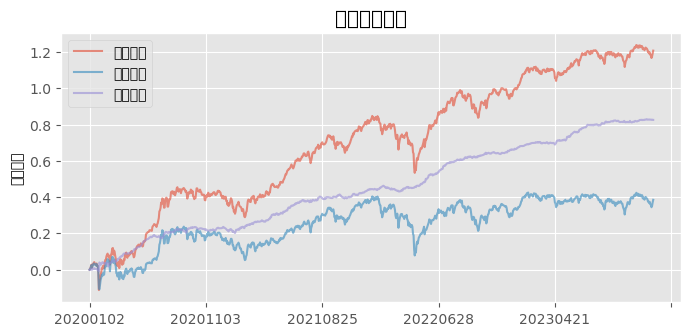

,指数收益,超额收益,策略收益
年化收益率,0.099,0.213,0.311
年化波动率,0.201,0.055,0.212
夏普率,0.495,3.843,1.468
最大回撤,-0.325,-0.034,-0.314
收益回撤比,0.305,6.272,0.992
胜率,0.534,0.586,0.576
盈亏比,0.948,1.445,0.944


Program 6: rank(up_KURS)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


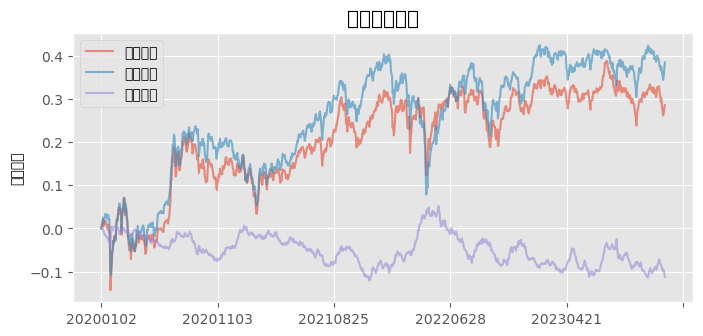

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.029,0.074
年化波动率,0.201,0.077,0.199
夏普率,0.495,-0.378,0.371
最大回撤,-0.325,-0.167,-0.196
收益回撤比,0.305,-0.174,0.375
胜率,0.534,0.468,0.532
盈亏比,0.948,1.065,0.937


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


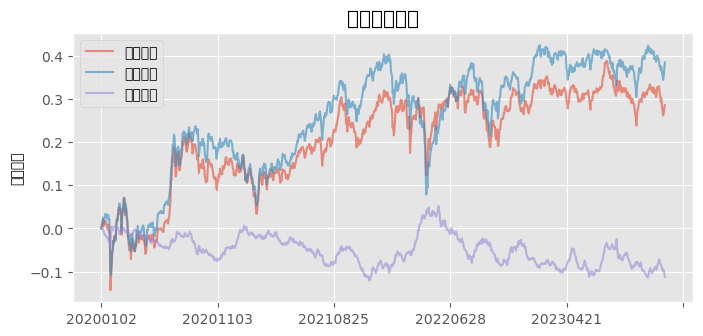

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.029,0.074
年化波动率,0.201,0.077,0.199
夏普率,0.495,-0.378,0.371
最大回撤,-0.325,-0.167,-0.196
收益回撤比,0.305,-0.174,0.375
胜率,0.534,0.468,0.532
盈亏比,0.948,1.065,0.937


Program 7: up_KURS
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


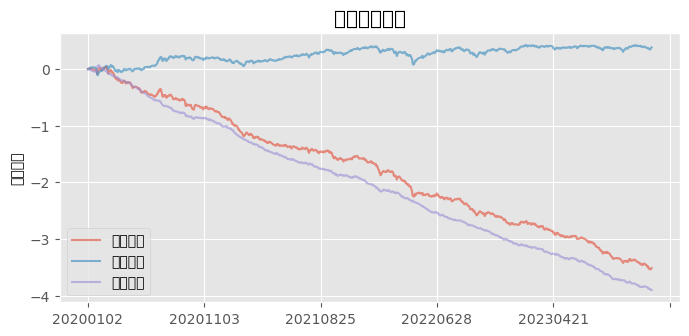

,指数收益,超额收益,策略收益
年化收益率,0.099,-1.005,-0.905
年化波动率,0.201,0.119,0.234
夏普率,0.495,-8.451,-3.864
最大回撤,-0.325,-3.968,-3.578
收益回撤比,0.305,-0.253,-0.253
胜率,0.534,0.273,0.414
盈亏比,0.948,0.664,0.739


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


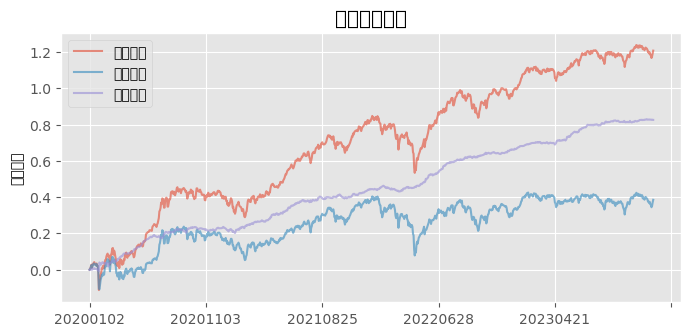

,指数收益,超额收益,策略收益
年化收益率,0.099,0.213,0.311
年化波动率,0.201,0.055,0.212
夏普率,0.495,3.843,1.468
最大回撤,-0.325,-0.034,-0.314
收益回撤比,0.305,6.272,0.992
胜率,0.534,0.586,0.576
盈亏比,0.948,1.445,0.944


Program 8: rank(up_KURS)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


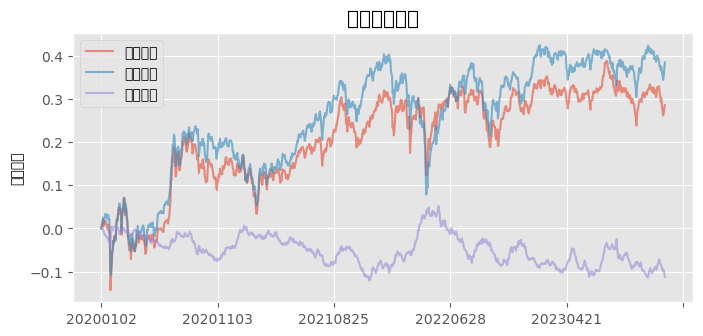

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.029,0.074
年化波动率,0.201,0.077,0.199
夏普率,0.495,-0.378,0.371
最大回撤,-0.325,-0.167,-0.196
收益回撤比,0.305,-0.174,0.375
胜率,0.534,0.468,0.532
盈亏比,0.948,1.065,0.937


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


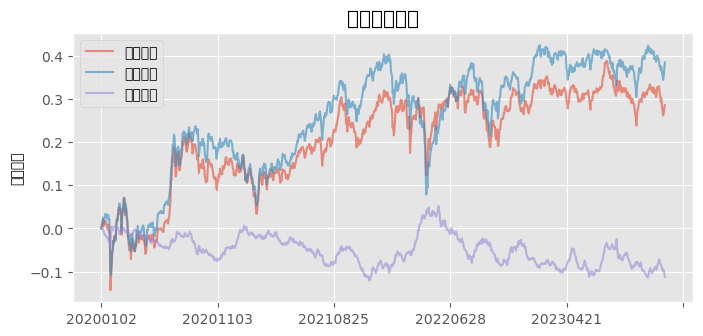

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.029,0.074
年化波动率,0.201,0.077,0.199
夏普率,0.495,-0.378,0.371
最大回撤,-0.325,-0.167,-0.196
收益回撤比,0.305,-0.174,0.375
胜率,0.534,0.468,0.532
盈亏比,0.948,1.065,0.937


Program 9: rank(up_KURS)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


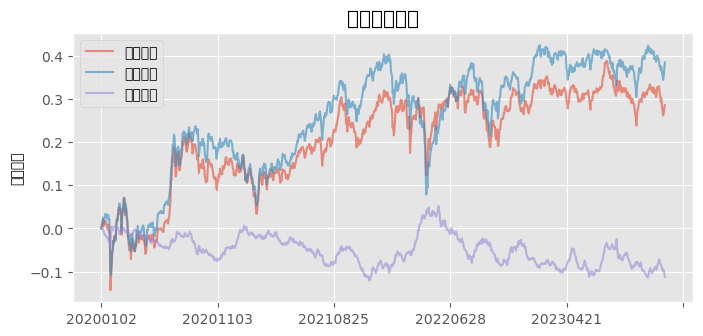

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.029,0.074
年化波动率,0.201,0.077,0.199
夏普率,0.495,-0.378,0.371
最大回撤,-0.325,-0.167,-0.196
收益回撤比,0.305,-0.174,0.375
胜率,0.534,0.468,0.532
盈亏比,0.948,1.065,0.937


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


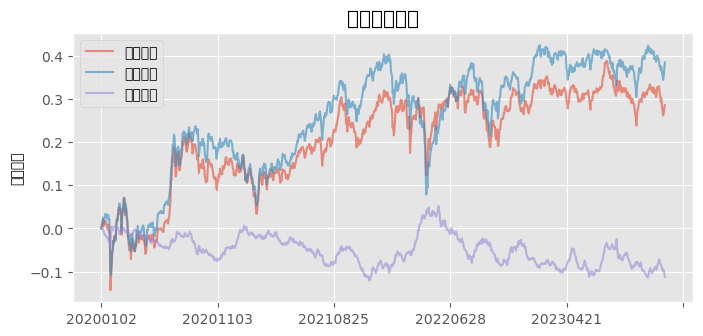

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.029,0.074
年化波动率,0.201,0.077,0.199
夏普率,0.495,-0.378,0.371
最大回撤,-0.325,-0.167,-0.196
收益回撤比,0.305,-0.174,0.375
胜率,0.534,0.468,0.532
盈亏比,0.948,1.065,0.937


Program 10: add(vol_mean, turnover_score_ts_std)
long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


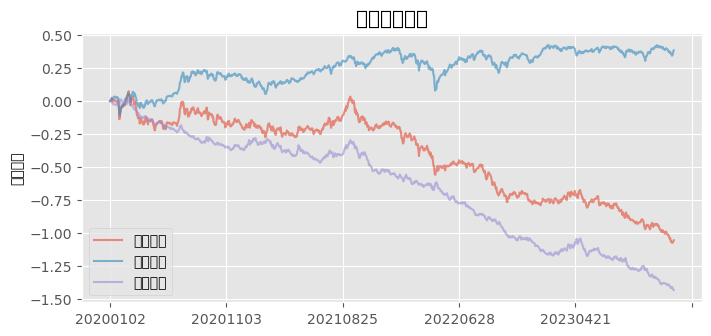

,指数收益,超额收益,策略收益
年化收益率,0.099,-0.370,-0.273
年化波动率,0.201,0.152,0.260
夏普率,0.495,-2.432,-1.047
最大回撤,-0.325,-1.455,-1.152
收益回撤比,0.305,-0.254,-0.237
胜率,0.534,0.415,0.489
盈亏比,0.948,0.946,0.877


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


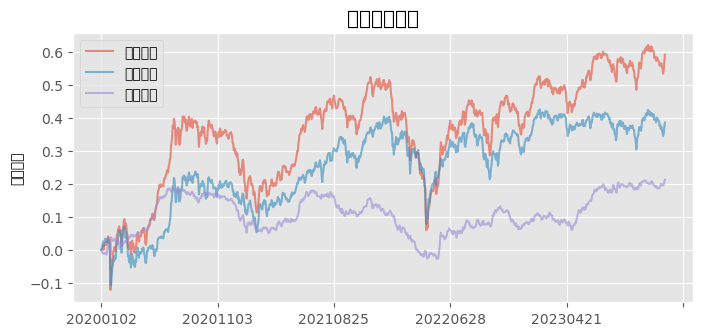

,指数收益,超额收益,策略收益
年化收益率,0.099,0.055,0.152
年化波动率,0.201,0.089,0.227
夏普率,0.495,0.618,0.673
最大回撤,-0.325,-0.214,-0.464
收益回撤比,0.305,0.256,0.329
胜率,0.534,0.505,0.552
盈亏比,0.948,1.088,0.911


In [59]:
transformed_factor = []
for i, program in enumerate(test_gp._best_programs):
    print(f'Program {i+1}: {program}')
    transformed_X = program.execute(np.nan_to_num(stock_all.loc[:,fields].values))
    transformed_factor_X = pd.DataFrame(transformed_X.reshape(close.shape[0],-1),index = close.index,columns = close.loc[:,'20200101':'20240101'].columns)
    a = ff.run(-transformed_factor_X*ff.filter0.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0)[0]
    b = ff.run(transformed_factor_X*ff.filter0.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0)[0]
    if a.iloc[0,2] > 0:
        result.loc[len(result)] = ('-'+str(program),a.iloc[2,2],a.iloc[0,2],10)
    else:
        result.loc[len(result)] = (str(program),b.iloc[2,2],b.iloc[0,2],10)

In [ ]:
add(ll30, bias15)

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


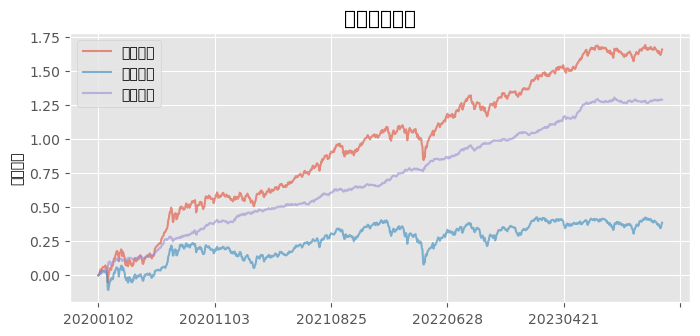

,指数收益,超额收益,策略收益
年化收益率,0.099,0.332,0.427
年化波动率,0.201,0.084,0.236
夏普率,0.495,3.929,1.805
最大回撤,-0.325,-0.043,-0.255
收益回撤比,0.305,7.698,1.674
胜率,0.534,0.590,0.574
盈亏比,0.948,1.343,1.002


(        指数收益   超额收益   策略收益
 年化收益率  0.099  0.332  0.427
 年化波动率  0.201  0.084  0.236
 夏普率    0.495  3.929  1.805
 最大回撤  -0.325 -0.043 -0.255
 收益回撤比  0.305  7.698  1.674
 胜率     0.534  0.590  0.574
 盈亏比    0.948  1.343  1.002,
                 策略     index          策略收益      指数收益      超额收益
 20200102  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200103  1.007326  1.004611  7.299021e-03  0.004600  0.002711
 20200106  1.018676  1.011856  1.850398e-02  0.011786  0.006759
 20200107  1.041342  1.024789  4.051057e-02  0.024486  0.016184
 20200108  1.027707  1.011282  2.733013e-02  0.011218  0.016270
 ...            ...       ...           ...       ...       ...
 20231225  5.087768  1.429845  1.626839e+00  0.357566  1.286265
 20231226  5.028655  1.411328  1.615153e+00  0.344531  1.287596
 20231227  5.070733  1.421573  1.623485e+00  0.351764  1.288704
 20231228  5.148283  1.448476  1.638663e+00  0.370512  1.285066
 20231229  5.235239  1.470119  1.655412e+00  0.385343  1.287012
 
 [970

In [34]:
ff.run((ff.read('ll30').loc[:,'20200101':'20240101'].rank()/ff.read('ll30').loc[:,'20200101':'20240101'].count() + ff.read('bias15').loc[:,'20200101':'20240101'].rank()/ff.read('bias15').loc[:,'20200101':'20240101'].count()) * ff.filter0.loc[:,'20200101':'20240101'], positions = 100, period = 1, fees = 0)

<Axes: >

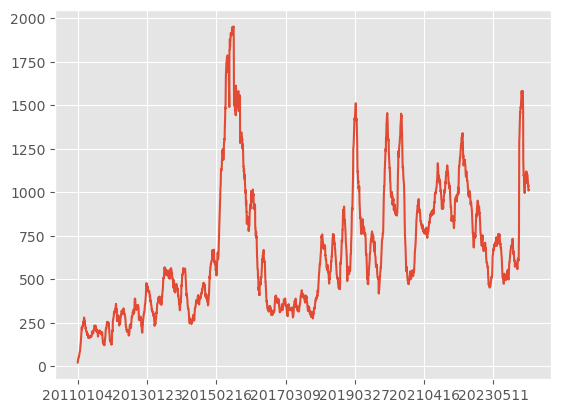

In [28]:
ff.read('ll30').count().plot()

In [31]:
(ff.read('ll30').loc[:,'20200101':'20240101'] + ff.read('bias15').loc[:,'20200101':'20240101']) * ff.filter0.loc[:,'20200101':'20240101']

,20200102,20200103,20200106,20200107,20200108,20200109,20200110,20200113,20200114,20200115,...,20231218,20231219,20231220,20231221,20231222,20231225,20231226,20231227,20231228,20231229
000001.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000002.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000004.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.001209,1.003582,0.995163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.004214,2.004265,2.000000,2.002165,2.0,2.002262,2.004591,2.002202,2.002198,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873726.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873806.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873833.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
920002.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
ff.read('ll30').loc[:,'20200101':'20240101'].rank()/ff.read('ll30').loc[:,'20200101':'20240101'].count()

,20200102,20200103,20200106,20200107,20200108,20200109,20200110,20200113,20200114,20200115,...,20231218,20231219,20231220,20231221,20231222,20231225,20231226,20231227,20231228,20231229
000001.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000002.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000004.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.299373,0.296148,0.292422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.702978,0.700642,0.697694,0.696399,0.690199,0.693333,0.692114,0.687937,0.700669,0.694167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873726.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873806.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873833.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
920002.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
